# Math 189

### Setup

In [44]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf

In [116]:
# Load the data
df = pd.read_csv('capes_data.csv')
df.head()

,Instructor,Course,Quarter,Total Enrolled in Course,Total CAPEs Given,Percentage Recommended Class,Percentage Recommended Professor,Study Hours per Week,Average Grade Expected,Average Grade Received,Evalulation URL
0,Butler Elizabeth Annette,AAS 10 - Intro/African-American Studies (A),SP23,66,48,93.5%,100.0%,2.80,A- (3.84),B+ (3.67),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
1,Butler Elizabeth Annette,AAS 170 - Legacies of Research (A),SP23,20,7,100.0%,100.0%,2.50,A- (3.86),A- (3.92),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
2,Jones Ian William Nasser,ANAR 111 - Foundations of Archaeology (A),SP23,16,3,100.0%,100.0%,3.83,B+ (3.67),NaN,https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
3,Shtienberg Gilad,ANAR 115 - Coastal Geomorphology/Environ (A),SP23,26,6,100.0%,83.3%,3.83,B+ (3.50),B (3.07),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
4,Braswell Geoffrey E.,ANAR 155 - Stdy Abrd: Ancient Mesoamerica (A),SP23,22,9,100.0%,100.0%,5.17,A (4.00),A (4.00),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...


### Data Cleaning

Since the evaluation URL does not have any influence on our result, it will be removed. In addition, we will remove the rows with missing values and update the sequence number. 

In [117]:
df = df.drop('Evalulation URL', axis=1)
df = df.drop('Instructor', axis=1)
df = df.dropna().reset_index(drop=True)

For later analysis, we will break the Average Grade Expected and Average Grade Received into letter grade and gpa and convert them into the appropriate data types.

In [118]:
#df['exp_letter'] = df['Average Grade Expected'].str.extract(r'^(\S+)')
#df['rec_letter'] = df['Average Grade Received'].str.extract(r'^(\S+)')

df['exp_gpa'] = df['Average Grade Expected'].str.extract(r'(\d+\.\d+)').astype(float)
df['rec_gpa'] = df['Average Grade Received'].str.extract(r'(\d+\.\d+)').astype(float)

df = df.drop('Average Grade Expected', axis=1)
df = df.drop('Average Grade Received', axis=1)

In [119]:
df['Quarter_Year'] = df['Quarter']
df['Quarter'] = df['Quarter'].str[0:2]
df['Quarter'] = df['Quarter'].replace(['S1', 'S2', 'S3', 'SU'], 'SS')
df['Quarter'] = df['Quarter'].astype('category')


In [120]:
df['cape_prop'] = df['Total CAPEs Given']/df['Total Enrolled in Course']
df = df.drop('Total CAPEs Given', axis=1)

Some other columns will be renamed for simplicity and converted to appropriate data types.

In [121]:
df = df.rename(columns={
    'Percentage Recommended Class': 'recmd_class',
    'Percentage Recommended Professor': 'recmd_prof',
    'Study Hours per Week': 'study_hrs',
    'Total Enrolled in Course' : 'enrollment'
})

df['recmd_class'] = df['recmd_class'].str.extract(r'(\d+)').astype(float)/100
df['recmd_prof'] = df['recmd_prof'].str.extract(r'(\d+)').astype(float)/100

In [122]:
# Split the course name into prefix and if it is a lower class
import re
course_info = df['Course'].apply(lambda x: re.findall(r"[\w+\s\d+]+\b", x)[0])
print(f"In total there are {course_info.apply(lambda x: x.split()[0]).value_counts().shape[0]} prefixs")
df['Course'] = pd.Series(course_info).apply(lambda x: x.split()[0])
if_lower = course_info.apply(lambda x: x.split()[1]).apply(lambda x: 1 if int(re.findall(r"\d+", x)[0]) < 100 else 0)
df['if_lower'] = if_lower
df.rename(columns={"Course" : "course_prefix"}, inplace=True)

In total there are 125 prefixs


Now, let's take a look at the cleaned dataset.

In [123]:
df.head()

,course_prefix,Quarter,enrollment,recmd_class,recmd_prof,study_hrs,exp_gpa,rec_gpa,Quarter_Year,cape_prop,if_lower
0,AAS,SP,66,0.93,1.00,2.80,3.84,3.67,SP23,0.727273,1
1,AAS,SP,20,1.00,1.00,2.50,3.86,3.92,SP23,0.350000,0
2,ANAR,SP,26,1.00,0.83,3.83,3.50,3.07,SP23,0.230769,0
3,ANAR,SP,22,1.00,1.00,5.17,4.00,4.00,SP23,0.409091,0
4,ANBI,SP,22,1.00,1.00,2.50,4.00,2.95,SP23,0.181818,0


### Exploratory Data Analysis

We can obtain a general understanding of the distribution of the average grade received by drawing a histogram before further analysis.

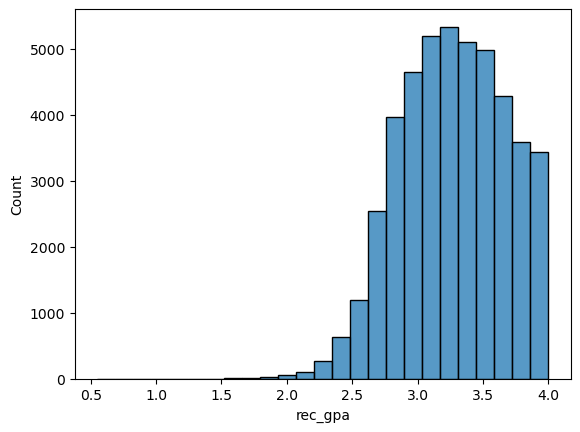

In [109]:
sns.histplot(df['rec_gpa'], bins=25)
plt.show()

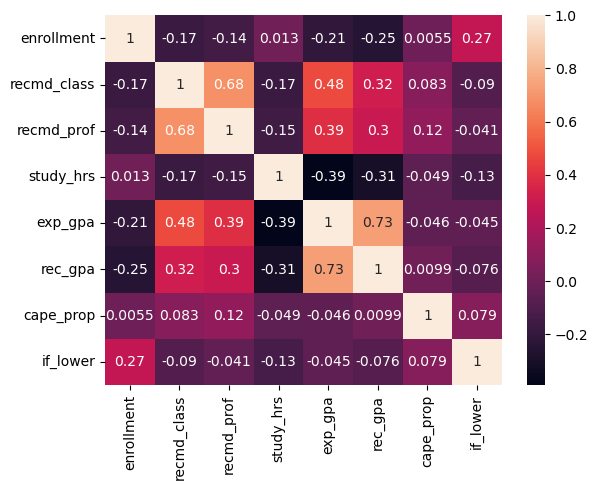

In [125]:
# Correlation
quan_data = df.drop(columns={
    #'Instructor',
    'course_prefix',
    'Quarter',
    'Quarter_Year',
    # 'Total Enrolled in Course',
    # 'Total CAPEs Given',
    # 'exp_letter',
    # 'rec_letter'
})
correlation_matrix = quan_data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

### Hypothesis Testing

### Regression Analysis

In [126]:
formula = 'rec_gpa ~ Quarter + enrollment + recmd_class + recmd_prof + study_hrs + exp_gpa + cape_prop'
model = smf.ols(formula, data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                rec_gpa   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     6075.
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        19:03:01   Log-Likelihood:                -5369.6
No. Observations:               45393   AIC:                         1.076e+04
Df Residuals:                   45383   BIC:                         1.085e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0475      0.019      2.437

In [127]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
exog = model.model.exog
names = model.params.index
for i in range(1, exog.shape[1]):
    print(f'VIF: {names[i]}: {variance_inflation_factor(exog, i):.3f}')

VIF: Quarter[T.SP]: 1.443
VIF: Quarter[T.SS]: 1.330
VIF: Quarter[T.WI]: 1.431
VIF: enrollment: 1.089
VIF: recmd_class: 2.082
VIF: recmd_prof: 1.905
VIF: study_hrs: 1.231
VIF: exp_gpa: 1.555
VIF: cape_prop: 1.071


My part starts here (Jiaxin Yang)

In [128]:
df_save = df.copy()

This part checking if the students recieved GPA is significantly impacted compare to the gpa students received before the COVID period. It could be much better or worse.  
Definition of Covid: Quarters from SS 2020 to SP 2023. Both inclusive.  
SS20 FA20 WI21 SP21 SS21 FA21 WI22 SP22 SS22 FA22 WI23 SP23

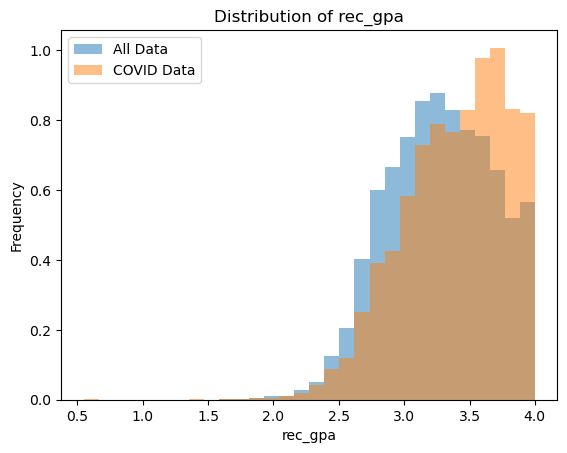

In [139]:
# Permutation test to see if the data is different

df_covid = df[df['Quarter_Year'].apply(lambda x : x in ['SS20', 'FA20', 'WI21', 'SP21', 'SS21', 'FA21', 'WI22', 'SP22', 'SS22', 'FA22', 'WI23', 'SP23'])]
# df['rec_gpa'].mean() 3.27194
# df_covid['rec_gpa'].mean() 3.390616

plt.hist(df['rec_gpa'], bins=30, alpha=0.5, label='All Data',density=True)
plt.hist(df_covid['rec_gpa'], bins=30, alpha=0.5, label='COVID Data', density=True)

plt.title('Distribution of rec_gpa')
plt.xlabel('rec_gpa')
plt.ylabel('Frequency')
plt.legend()
plt.show()


It looks like the GPA during the Covid time is slightly higher than other time.  
In order to justify that, lets do a permutation test!

Observed mse diff: -0.002616766507527124
P-value: 0.2654


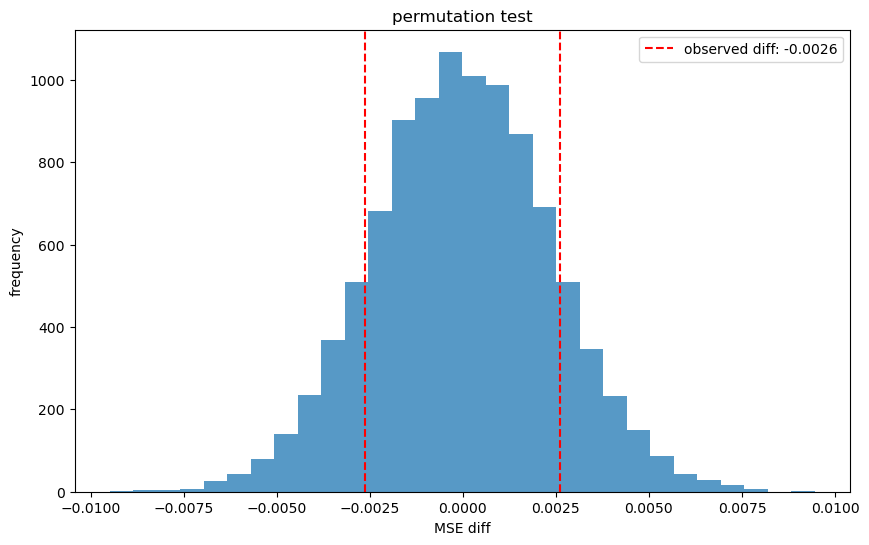

In [142]:
def mse_difference(data1, data2):
    return np.mean((data1 - np.mean(data2)) ** 2) - np.mean((data2 - np.mean(data1)) ** 2)


observed_mse_diff = mse_difference(df_covid['rec_gpa'], df[~df['Quarter_Year'].isin(df_covid['Quarter_Year'])]['rec_gpa'])

combined_data = np.concatenate([df_covid['rec_gpa'], df[~df['Quarter_Year'].isin(df_covid['Quarter_Year'])]['rec_gpa']])

num_permutations = 10000

permuted_mse_diffs = np.zeros(num_permutations)

for i in range(num_permutations):

    permuted_data = np.random.permutation(combined_data)

    permuted_sample1 = permuted_data[:len(df_covid)]
    permuted_sample2 = permuted_data[len(df_covid):]

    permuted_mse_diffs[i] = mse_difference(permuted_sample1, permuted_sample2)

p_value = np.mean(np.abs(permuted_mse_diffs) >= np.abs(observed_mse_diff))

# print(f'Observed mse diff: {observed_mse_diff}')
print(f'P-value: {p_value}')


plt.figure(figsize=(10, 6))
plt.hist(permuted_mse_diffs, bins=30, alpha=0.75)
plt.axvline(observed_mse_diff, color='red', linestyle='--', label=f'observed diff: {observed_mse_diff:.4f}')
plt.axvline(-observed_mse_diff, color='red', linestyle='--')
plt.title('permutation test')
plt.xlabel('MSE diff')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [38]:
# Only take rows with more than 50% evaluating proportion
# df = df_save.copy()
# df = df[df['cape_prop'] > 0.50] # 45393 -> 18860

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df[['enrollment', 'recmd_class', 'recmd_prof', 'study_hrs', 'exp_gpa', 'cape_prop', 'if_lower']]
y = df['rec_gpa']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Correlation coefficient score: {r2}')



Mean Squared Error: 0.06368828523697678
Correlation coefficient score: 0.5754774429171827


In [42]:
# Prediction to a made-up date
new_data = [[30, 0.95, 0.90, 3.0, 3.75, 0.5, 1]]
predicted_gpa = model.predict(new_data)
print(f'Predicted GPA: {predicted_gpa[0]}')


Predicted GPA: 3.5326396931641786


c:\Users\jiaxin\miniforge3\envs\dsc80\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [43]:
coefficients = pd.DataFrame(model.coef_, index=X.columns, columns=['Coefficient'])
coefficients
# Which feature has the highest regression coefficient (influence)

,Coefficient
enrollment,-0.000330
recmd_class,-0.321649
recmd_prof,0.108724
study_hrs,0.002201
exp_gpa,1.076500
cape_prop,0.139787
if_lower,-0.021326


According to our Linear Regression predicting model, Expected GPA in all features has